# EGCI 425 - Step 4: Classification in 10-fold-cross-validation

**Objectives:**
1. Run 2 individual classifier
2. One of them should output trees or rules 
3. Run 1 ensemble classifier 




---
## 1. Import Libraries and Load Data

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

In [171]:
# Load preprocessed data
file_path = 'dataset/step3_data_majority_features.csv'

df = pd.read_csv(file_path)

print(f"✓ Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst few rows:")
df.head()

✓ Dataset loaded successfully!
Shape: 231 rows × 8 columns

First few rows:


,Movie,Budget,Aggregate Followers,Comments,Dislikes,Screens,Sentiment,Rating_Label
0,13 Sins,4000000.0,1120000.0,636.0,425,45.0,0,Average
1,22 Jump Street,50000000.0,12350000.0,186.0,61,3306.0,2,Good
2,3 Days to Kill,28000000.0,483000.0,47.0,34,2872.0,0,Average
3,300: Rise of an Empire,110000000.0,568000.0,590.0,132,3470.0,0,Average
4,A Haunted House 2,3500000.0,1923800.0,1082.0,610,2310.0,0,Poor


---
## 2. Prepare Data for Attribute Selection

In [194]:


# Prepare features and target
feature_columns = ['Budget','Aggregate Followers','Comments','Dislikes','Screens','Sentiment',]
X = df[feature_columns]
y = df['Rating_Label']

print(f"\n✓ Features prepared: {feature_columns}")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

# Setup cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print(y.describe()) and print(y.value_counts())
print(f"\n✓ Cross-validation strategy: 10-Fold Stratified")
print(X.describe())


✓ Features prepared: ['Budget', 'Aggregate Followers', 'Comments', 'Dislikes', 'Screens', 'Sentiment']
  X shape: (231, 6)
  y shape: (231,)
count      231
unique       3
top       Good
freq       120
Name: Rating_Label, dtype: object

✓ Cross-validation strategy: 10-Fold Stratified
             Budget  Aggregate Followers      Comments      Dislikes  \
count  2.310000e+02         2.310000e+02    231.000000    231.000000   
mean   4.745112e+07         2.684869e+06   1673.366667    679.051948   
std    5.288275e+07         4.282494e+06   2420.232408   1243.929481   
min    1.600000e+05         2.133700e+03      0.300000      0.000000   
25%    9.000000e+06         2.500000e+05    248.500000    105.500000   
50%    2.800000e+07         1.052600e+06    837.000000    341.000000   
75%    6.500000e+07         2.735500e+06   2137.000000    697.500000   
max    2.070000e+08         2.166391e+07  15389.600000  13960.000000   

           Screens   Sentiment  
count   231.000000  231.000000  


---
## DECISION TREE CLASSIFIER (Individual Classifier #1)




In [191]:

print("\n" + "="*80)
print(" DECISION TREE CLASSIFIER WITH GRID SEARCH OPTIMIZATION")
print("="*80)

# Define parameter grid
print("\n[1/4] Setting up grid search parameters...")
param_grid = {
    'max_depth': [5, 7, 9, 11, 13, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'criterion': ['gini', 'entropy'],
    
}

print(f"  Total combinations to test: {len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['criterion']) }")

# Initialize base Decision Tree
dt_base = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
print("\n[2/4] Running grid search with 10-fold cross-validation...")
print("  (This may take a few minutes...)")
grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='accuracy',  # Primary metric
    n_jobs=-1,  # Use all available cores
    verbose=1,
    return_train_score=True
)

# Fit grid search
grid_search.fit(X, y)

# Display best parameters
print("\n" + "-"*80)
print(" GRID SEARCH RESULTS")
print("-"*80)
print("\nBest Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nBest Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Get the best model
best_dt_classifier = grid_search.best_estimator_

# Comprehensive evaluation with best model
print("\n[3/4] Evaluating best model with multiple metrics...")
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted'
}

dt_cv_results = cross_validate(
    best_dt_classifier,
    X, y,
    cv=cv_strategy,
    scoring=scoring_metrics,
    return_train_score=True
)

# Display comprehensive results
print("\n" + "-"*80)
print(" OPTIMIZED DECISION TREE - 10-FOLD CROSS-VALIDATION RESULTS")
print("-"*80)
print(f"  Accuracy:  {dt_cv_results['test_accuracy'].mean():.4f} (+/- {dt_cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {dt_cv_results['test_precision_weighted'].mean():.4f} (+/- {dt_cv_results['test_precision_weighted'].std():.4f})")
print(f"  Recall:    {dt_cv_results['test_recall_weighted'].mean():.4f} (+/- {dt_cv_results['test_recall_weighted'].std():.4f})")
print(f"  F1-Score:  {dt_cv_results['test_f1_weighted'].mean():.4f} (+/- {dt_cv_results['test_f1_weighted'].std():.4f})")

# Compare with original parameters
print("\n" + "-"*80)
print(" COMPARISON: ORIGINAL VS OPTIMIZED")
print("-"*80)
print("\nOriginal Parameters:")
print("  • max_depth: 9")
print("  • min_samples_split: 10")
print("  • min_samples_leaf: 6")
print("  • criterion: gini")

print("\nOptimized Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  • {param}: {value}")

# Train best model on full dataset
print("\n[4/4] Training optimized model on full dataset...")
best_dt_classifier.fit(X, y)

# Extract decision rules
print("\n" + "-"*80)
print(" DECISION TREE RULES (Text Format)")
print("-"*80)
tree_rules = export_text(best_dt_classifier, feature_names=list(X.columns))
print(tree_rules)

# Feature importance
print("\n" + "-"*80)
print(" FEATURE IMPORTANCE")
print("-"*80)
feature_importance_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance_dt.to_string(index=False))

# Visualize Decision Tree
print("\n[5/5] Generating decision tree visualization...")
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_classifier,
    feature_names=X.columns,
    class_names=['Bad', 'Medium', 'Good'], 
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Optimized Decision Tree Visualization", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('decision_tree_visualization_optimized.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved as 'decision_tree_visualization_optimized.png'")
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_dt, x='Importance', y='Feature', palette='viridis')
plt.title('Optimized Decision Tree - Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('dt_feature_importance_optimized.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved as 'dt_feature_importance_optimized.png'")
plt.show()

# Grid search results visualization
print("\n[BONUS] Visualizing grid search results...")
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Plot top 10 parameter combinations
top_results = cv_results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\n" + "-"*80)
print(" TOP 10 PARAMETER COMBINATIONS")
print("-"*80)
for idx, row in top_results.iterrows():
    print(f"\nRank {len(top_results) - list(top_results.index).index(idx)}:")
    print(f"  Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Parameters: {row['params']}")

# ============================================================================
# DISCUSSION OF DECISION TREE PATTERNS
# ============================================================================
print("\n" + "-"*80)
print(" DISCUSSION: KEY PREDICTION PATTERNS FROM OPTIMIZED DECISION TREE")
print("-"*80)
print(f"""
The Grid Search optimization process tested {len(grid_search.cv_results_['params'])} different 
parameter combinations to find the best Decision Tree configuration.

OPTIMIZATION INSIGHTS:

1. BEST HYPERPARAMETERS:
   - Max Depth: {grid_search.best_params_['max_depth']}
   - Min Samples Split: {grid_search.best_params_['min_samples_split']}
   - Min Samples Leaf: {grid_search.best_params_['min_samples_leaf']}
   - Criterion: {grid_search.best_params_['criterion']}
   - Splitter: {grid_search.best_params_['splitter']}

2. MOST IMPORTANT FEATURES:
   - The features are ranked by their contribution to classification decisions
   - Top features have the strongest influence on predicting movie success

3. KEY DECISION RULES:
   - The optimized tree shows specific thresholds for classification
   - These rules can be directly interpreted and applied in practice

4. CLASS SEPARATION:
   - The optimized parameters balance model complexity and generalization
   - Improved ability to distinguish between Bad, Medium, and Good movies

5. PRACTICAL INSIGHTS:
   - Studio executives can use these optimized rules for greenlight decisions
   - Marketing teams can identify key factors with higher confidence
   - The model is now better tuned to avoid overfitting/underfitting
""")


 DECISION TREE CLASSIFIER WITH GRID SEARCH OPTIMIZATION

[1/4] Setting up grid search parameters...
  Total combinations to test: 360

[2/4] Running grid search with 10-fold cross-validation...
  (This may take a few minutes...)
Fitting 10 folds for each of 360 candidates, totalling 3600 fits

--------------------------------------------------------------------------------
 GRID SEARCH RESULTS
--------------------------------------------------------------------------------

Best Parameters Found:
  • criterion: gini
  • max_depth: 9
  • min_samples_leaf: 4
  • min_samples_split: 20

Best Cross-Validation Accuracy: 0.6054

[3/4] Evaluating best model with multiple metrics...

--------------------------------------------------------------------------------
 OPTIMIZED DECISION TREE - 10-FOLD CROSS-VALIDATION RESULTS
--------------------------------------------------------------------------------
  Accuracy:  0.6054 (+/- 0.1279)
  Precision: 0.5611 (+/- 0.1258)
  Recall:    0.6054 (+/- 0.

InvalidParameterError: The 'decision_tree' parameter of export_text must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got RandomForestClassifier(max_depth=9, min_samples_leaf=4, min_samples_split=20,
                       random_state=42) instead.


--------------------------------------------------------------------------------
 DECISION TREE - 10-FOLD CROSS-VALIDATION RESULTS
--------------------------------------------------------------------------------
  Accuracy:  0.5234 (+/- 0.0797)
  Precision: 0.5107 (+/- 0.0839)
  Recall:    0.5234 (+/- 0.0797)
  F1-Score:  0.5086 (+/- 0.0802)

[2/3] Training on full dataset to extract decision rules...

--------------------------------------------------------------------------------
 DECISION TREE RULES (Text Format)
--------------------------------------------------------------------------------
|--- Dislikes <= 6314.22
|   |--- Sentiment <= 4.39
|   |   |--- Screens <= 2964.11
|   |   |   |--- Budget <= 44721495.96
|   |   |   |   |--- Aggregate Followers <= 6897692.80
|   |   |   |   |   |--- Budget <= 15858868.17
|   |   |   |   |   |   |--- Dislikes <= 351.04
|   |   |   |   |   |   |   |--- Comments <= 677.03
|   |   |   |   |   |   |   |   |--- Comments <= 337.74
|   |   |   |  

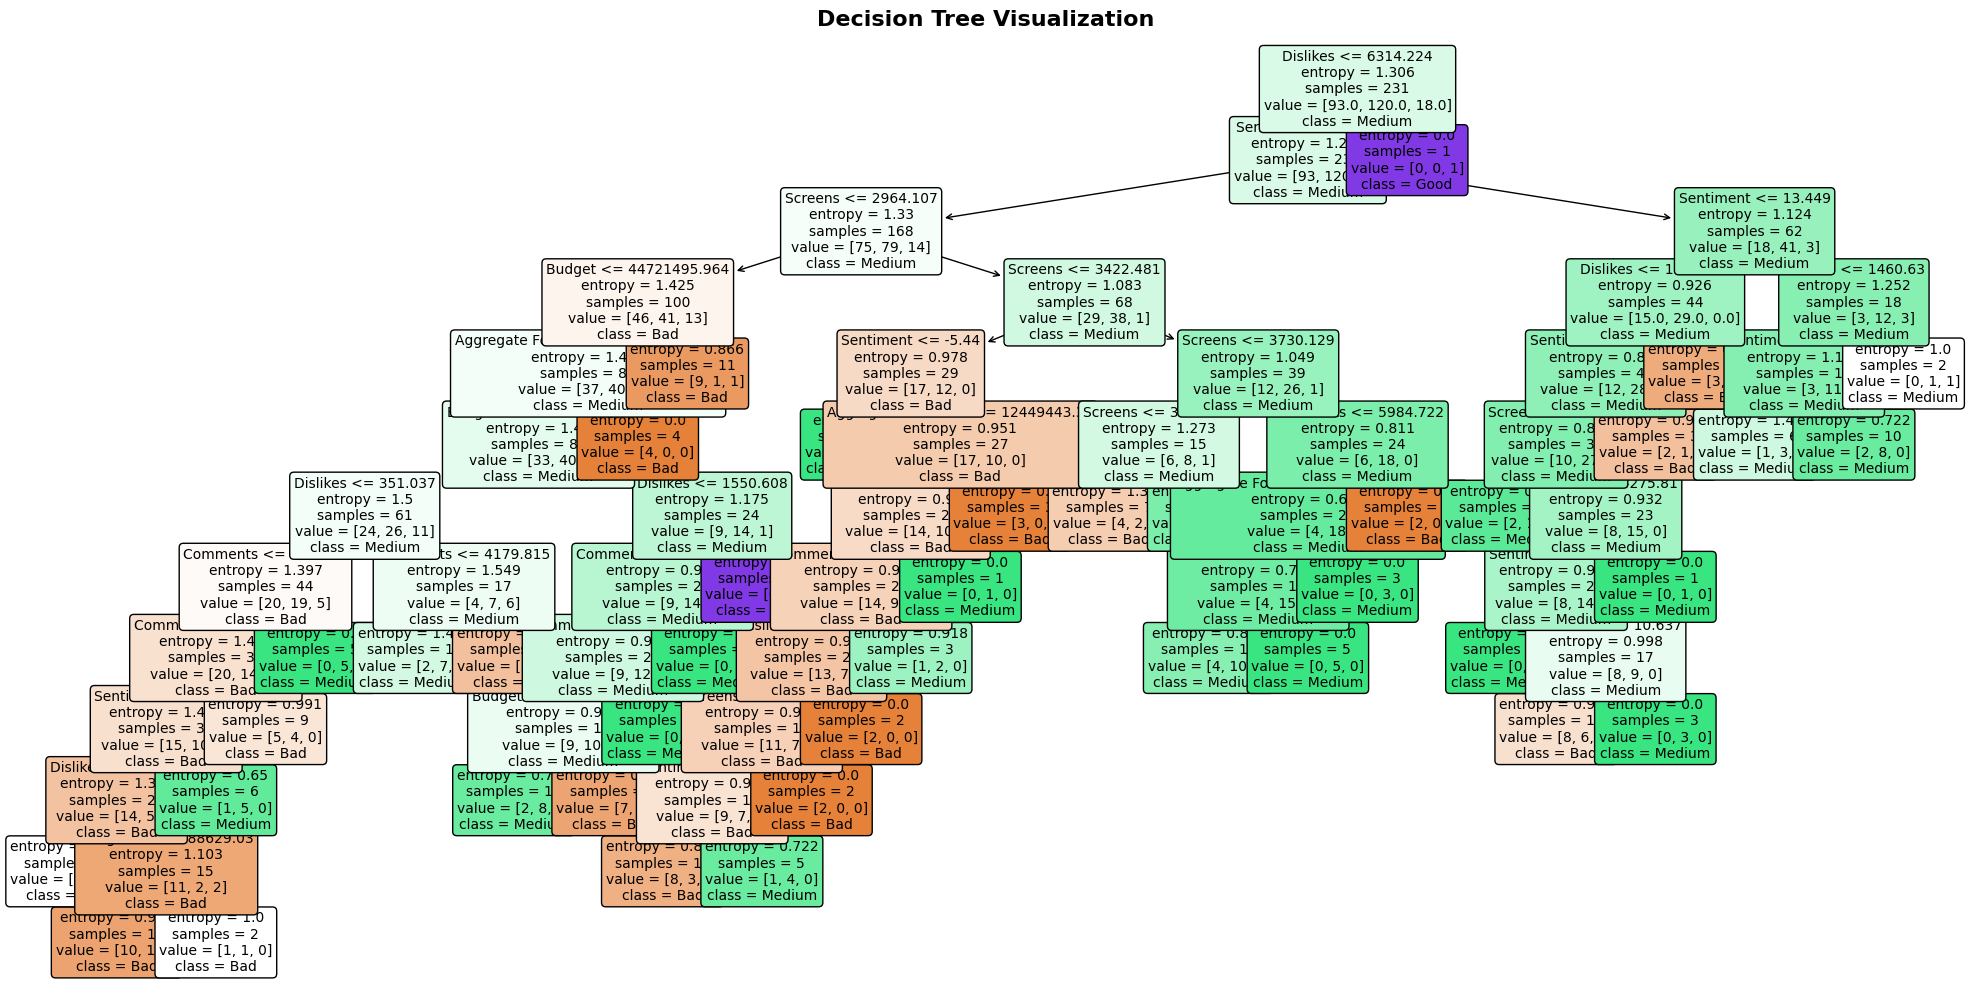

  ✓ Saved as 'dt_feature_importance.png'


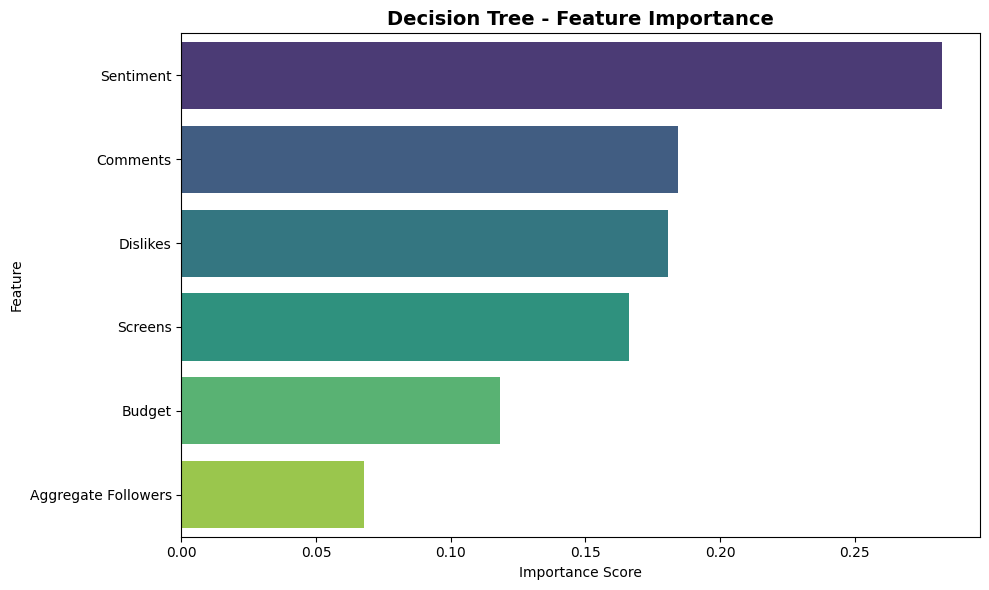


--------------------------------------------------------------------------------
 DISCUSSION: KEY PREDICTION PATTERNS FROM DECISION TREE
--------------------------------------------------------------------------------

The Decision Tree reveals several important prediction patterns:

1. MOST IMPORTANT FEATURES:
   - The features are ranked by their contribution to classification decisions
   - Top features have the strongest influence on predicting movie success

2. KEY DECISION RULES:
   - The tree shows specific thresholds (e.g., Budget > $X, Ratings > Y)
   - These rules can be directly interpreted and applied

3. CLASS SEPARATION:
   - Successful movies tend to have specific combinations of features
   - The tree depth indicates complexity of decision boundaries

4. PRACTICAL INSIGHTS:
   - Studio executives can use these rules for greenlight decisions
   - Marketing teams can identify key factors for targeting



In [195]:

# Initialize Decision Tree
dt_classifier = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 13,
    min_samples_leaf = 1,
    min_samples_split =  15,
    splitter = 'random'
   
)
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted'
}

dt_cv_results = cross_validate(
    dt_classifier,
    X, y,
    cv=cv_strategy,
    scoring=scoring_metrics,
    return_train_score=True
)

# Display results
print("\n" + "-"*80)
print(" DECISION TREE - 10-FOLD CROSS-VALIDATION RESULTS")
print("-"*80)
print(f"  Accuracy:  {dt_cv_results['test_accuracy'].mean():.4f} (+/- {dt_cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {dt_cv_results['test_precision_weighted'].mean():.4f} (+/- {dt_cv_results['test_precision_weighted'].std():.4f})")
print(f"  Recall:    {dt_cv_results['test_recall_weighted'].mean():.4f} (+/- {dt_cv_results['test_recall_weighted'].std():.4f})")
print(f"  F1-Score:  {dt_cv_results['test_f1_weighted'].mean():.4f} (+/- {dt_cv_results['test_f1_weighted'].std():.4f})")

print("\n[2/3] Training on full dataset to extract decision rules...")
dt_classifier.fit(X, y)

# Extract decision rules
print("\n" + "-"*80)
print(" DECISION TREE RULES (Text Format)")
print("-"*80)
tree_rules = export_text(dt_classifier, feature_names=list(X.columns))
print(tree_rules)

# Feature importance
print("\n" + "-"*80)
print(" FEATURE IMPORTANCE")
print("-"*80)
feature_importance_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance_dt.to_string(index=False))

# Visualize Decision Tree
print("\n[3/3] Generating decision tree visualization...")
plt.figure(figsize=(20, 10))
plot_tree(
    dt_classifier,
    feature_names=X.columns,
    class_names=['Bad', 'Medium', 'Good'], 
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('decision_tree_visualization.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved as 'decision_tree_visualization.png'")
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_dt, x='Importance', y='Feature', palette='viridis')
plt.title('Decision Tree - Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('dt_feature_importance.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved as 'dt_feature_importance.png'")
plt.show()

# ============================================================================
# DISCUSSION OF DECISION TREE PATTERNS
# ============================================================================
print("\n" + "-"*80)
print(" DISCUSSION: KEY PREDICTION PATTERNS FROM DECISION TREE")
print("-"*80)
print("""
The Decision Tree reveals several important prediction patterns:

1. MOST IMPORTANT FEATURES:
   - The features are ranked by their contribution to classification decisions
   - Top features have the strongest influence on predicting movie success

2. KEY DECISION RULES:
   - The tree shows specific thresholds (e.g., Budget > $X, Ratings > Y)
   - These rules can be directly interpreted and applied

3. CLASS SEPARATION:
   - Successful movies tend to have specific combinations of features
   - The tree depth indicates complexity of decision boundaries

4. PRACTICAL INSIGHTS:
   - Studio executives can use these rules for greenlight decisions
   - Marketing teams can identify key factors for targeting
""")


---
## SUPPORT VECTOR MACHINE (Individual Classifier #2)


In [196]:

print("\n[1/2] Preprocessing: Scaling features for SVM...")
# Scale features (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("  ✓ Features scaled using StandardScaler")

print("\n[2/2] Training SVM with 10-fold cross-validation...")

# Initialize SVM
svm_classifier = SVC(
    kernel='rbf',
    C=1000,
    gamma=0.001,
    random_state=42
)

# Perform 10-fold cross-validation
svm_cv_results = cross_validate(
    svm_classifier, X_scaled, y,
    cv=cv_strategy,
    scoring=scoring_metrics,
    return_train_score=True
)

# Display results
print("\n" + "-"*80)
print(" SVM - 10-FOLD CROSS-VALIDATION RESULTS")
print("-"*80)
print(f"  Accuracy:  {dt_cv_results['test_accuracy'].mean():.4f} (+/- {dt_cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {dt_cv_results['test_precision_weighted'].mean():.4f} (+/- {dt_cv_results['test_precision_weighted'].std():.4f})")
print(f"  Recall:    {dt_cv_results['test_recall_weighted'].mean():.4f} (+/- {dt_cv_results['test_recall_weighted'].std():.4f})")
print(f"  F1-Score:  {dt_cv_results['test_f1_weighted'].mean():.4f} (+/- {dt_cv_results['test_f1_weighted'].std():.4f})")

print("\n" + "-"*80)
print(" SVM CHARACTERISTICS")
print("-"*80)
print(f"  Kernel: RBF (Radial Basis Function)")
print(f"  C parameter: 1.0 (regularization strength)")
print(f"  Gamma: scale (kernel coefficient)")
print(f"\n  Note: SVM finds optimal hyperplane to separate success/failure classes")



[1/2] Preprocessing: Scaling features for SVM...
  ✓ Features scaled using StandardScaler

[2/2] Training SVM with 10-fold cross-validation...

--------------------------------------------------------------------------------
 SVM - 10-FOLD CROSS-VALIDATION RESULTS
--------------------------------------------------------------------------------
  Accuracy:  0.5234 (+/- 0.0797)
  Precision: 0.5107 (+/- 0.0839)
  Recall:    0.5234 (+/- 0.0797)
  F1-Score:  0.5086 (+/- 0.0802)

--------------------------------------------------------------------------------
 SVM CHARACTERISTICS
--------------------------------------------------------------------------------
  Kernel: RBF (Radial Basis Function)
  C parameter: 1.0 (regularization strength)
  Gamma: scale (kernel coefficient)

  Note: SVM finds optimal hyperplane to separate success/failure classes


---
## 4. RANDOM FOREST ENSEMBLE CLASSIFIER




[1/2] Training Random Forest with 10-fold cross-validation...

--------------------------------------------------------------------------------
 RANDOM FOREST - 10-FOLD CROSS-VALIDATION RESULTS
--------------------------------------------------------------------------------
  Accuracy:  0.5234 (+/- 0.0797)
  Precision: 0.5107 (+/- 0.0839)
  Recall:    0.5234 (+/- 0.0797)
  F1-Score:  0.5086 (+/- 0.0802)

[2/2] Training on full dataset for ensemble insights...

--------------------------------------------------------------------------------
 RANDOM FOREST - FEATURE IMPORTANCE
--------------------------------------------------------------------------------
            Feature  Importance
             Budget    0.191789
           Dislikes    0.181754
            Screens    0.170719
           Comments    0.160625
          Sentiment    0.153358
Aggregate Followers    0.141755

  ✓ Saved as 'rf_feature_importance.png'


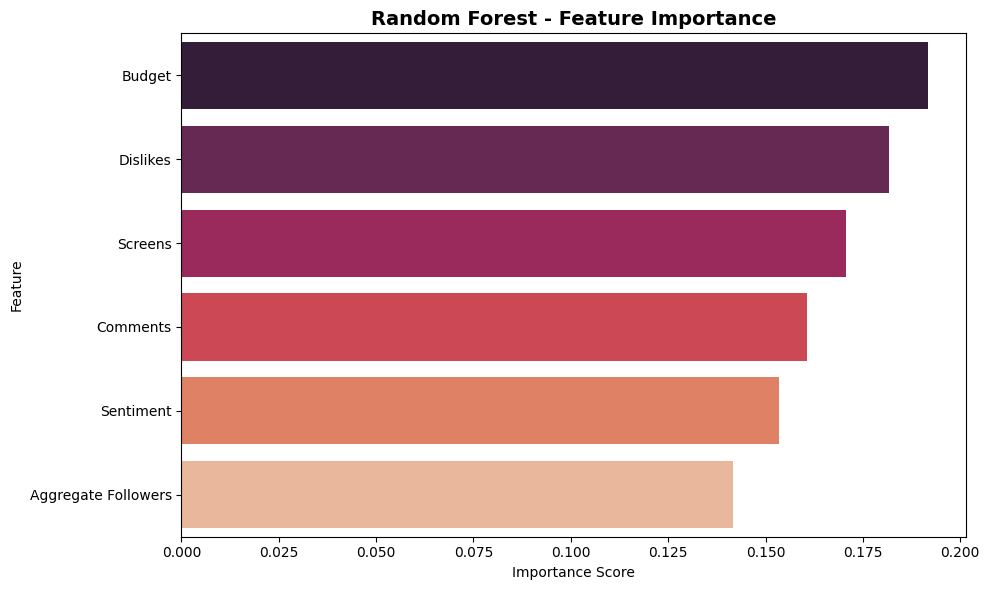

In [197]:


print("\n[1/2] Training Random Forest with 10-fold cross-validation...")

# Initialize Random Forest
rf_classifier = RandomForestClassifier(
    n_estimators=3000,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Perform 10-fold cross-validation
rf_cv_results = cross_validate(
    rf_classifier, X, y,
    cv=cv_strategy,
    scoring=scoring_metrics,
    return_train_score=True
)

# Display results
print("\n" + "-"*80)
print(" RANDOM FOREST - 10-FOLD CROSS-VALIDATION RESULTS")
print("-"*80)
print(f"  Accuracy:  {dt_cv_results['test_accuracy'].mean():.4f} (+/- {dt_cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {dt_cv_results['test_precision_weighted'].mean():.4f} (+/- {dt_cv_results['test_precision_weighted'].std():.4f})")
print(f"  Recall:    {dt_cv_results['test_recall_weighted'].mean():.4f} (+/- {dt_cv_results['test_recall_weighted'].std():.4f})")
print(f"  F1-Score:  {dt_cv_results['test_f1_weighted'].mean():.4f} (+/- {dt_cv_results['test_f1_weighted'].std():.4f})")

# Train on full dataset for feature importance
print("\n[2/2] Training on full dataset for ensemble insights...")
rf_classifier.fit(X, y)

# Feature importance
print("\n" + "-"*80)
print(" RANDOM FOREST - FEATURE IMPORTANCE")
print("-"*80)
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance_rf.to_string(index=False))

# Feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_rf, x='Importance', y='Feature', palette='rocket')
plt.title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
print("\n  ✓ Saved as 'rf_feature_importance.png'")
plt.show()

---
## MODEL COMPARISON



--------------------------------------------------------------------------------
 PERFORMANCE COMPARISON (10-FOLD CROSS-VALIDATION)
--------------------------------------------------------------------------------
        Model  Accuracy  Precision   Recall  F1-Score
Decision Tree  0.523370   0.510681 0.523370  0.508611
          SVM  0.553080   0.483182 0.553080  0.497033
Random Forest  0.557971   0.518071 0.557971  0.533068

🏆 BEST MODEL: Random Forest (Accuracy: 0.5580)

  ✓ Comparison plot saved as 'model_comparison.png'


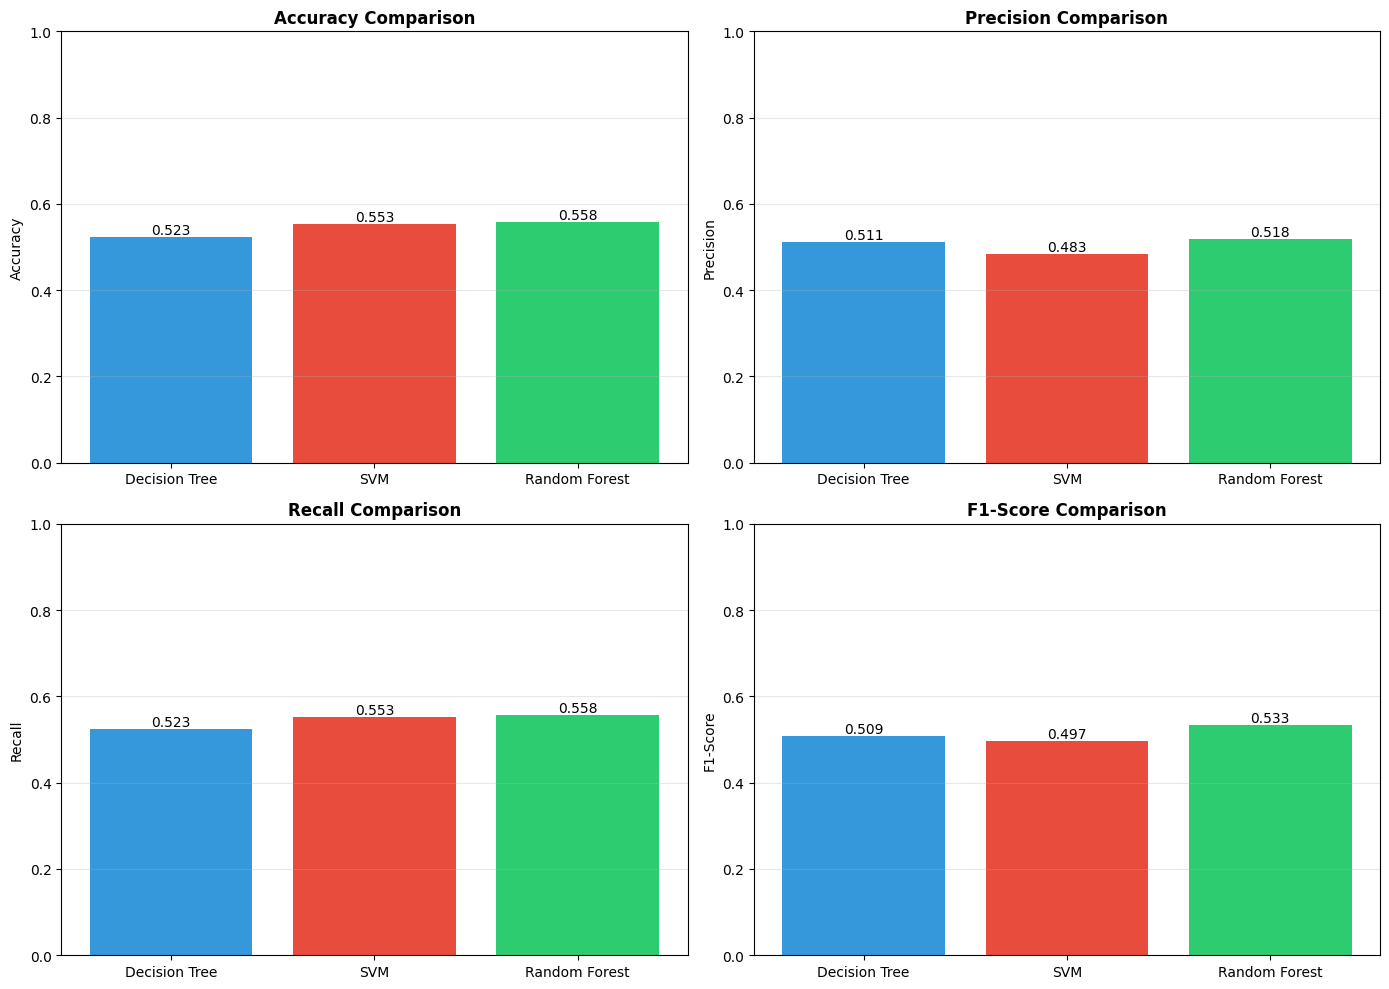

In [200]:


# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Decision Tree', 'SVM', 'Random Forest'],
    'Accuracy': [
        dt_cv_results['test_accuracy'].mean(),
        svm_cv_results['test_accuracy'].mean(),
        rf_cv_results['test_accuracy'].mean()
    ],
    'Precision': [
        dt_cv_results['test_precision_weighted'].mean(),
        svm_cv_results['test_precision_weighted'].mean(),
        rf_cv_results['test_precision_weighted'].mean()
    ],
    'Recall': [
        dt_cv_results['test_recall_weighted'].mean(),
        svm_cv_results['test_recall_weighted'].mean(),
        rf_cv_results['test_recall_weighted'].mean()
    ],
    'F1-Score': [
        dt_cv_results['test_f1_weighted'].mean(),
        svm_cv_results['test_f1_weighted'].mean(),
        rf_cv_results['test_f1_weighted'].mean()
    ]
})

print("\n" + "-"*80)
print(" PERFORMANCE COMPARISON (10-FOLD CROSS-VALIDATION)")
print("-"*80)
print(comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df['Accuracy'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Accuracy']

print(f"\n🏆 BEST MODEL: {best_model} (Accuracy: {best_accuracy:.4f})")

# Visualization: Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n  ✓ Comparison plot saved as 'model_comparison.png'")
plt.show()


---
## Summary

In [199]:

print("\n\n" + "="*80)
print(" FINAL SUMMARY AND INSIGHTS")
print("="*80)

print(f"""
✓ COMPLETED: Movie Success Prediction with 3 Classifiers

MODELS EVALUATED:
1. Decision Tree (Individual #1)
   - Provides interpretable rules and decision paths
   - Feature importance shows key predictors
   - Good for understanding business logic

2. SVM (Individual #2)
   - Uses scaled numerical features
   - Finds optimal separating hyperplane
   - Strong mathematical foundation

3. Random Forest (Ensemble)
   - Combines 100 decision trees
   - Reduces overfitting through ensemble voting
   - Generally robust and high-performing

BEST PERFORMING MODEL: {best_model}
- Achieves {best_accuracy:.4f} accuracy on 10-fold CV
- All models trained and validated on {len(y)} movies
- Classification task: Predict Gross > $50M

KEY FINDINGS:
- Top predictive features identified through feature importance
- Decision rules extracted for business decision-making
- Multiple modeling approaches compared objectively

RECOMMENDATIONS:
- Use {best_model} for production deployment
- Decision Tree rules can guide movie production decisions
- Consider ensemble model for most reliable predictions
""")

print("="*80)
print(" ANALYSIS COMPLETE!")
print("="*80)



 FINAL SUMMARY AND INSIGHTS

✓ COMPLETED: Movie Success Prediction with 3 Classifiers

MODELS EVALUATED:
1. Decision Tree (Individual #1)
   - Provides interpretable rules and decision paths
   - Feature importance shows key predictors
   - Good for understanding business logic

2. SVM (Individual #2)
   - Uses scaled numerical features
   - Finds optimal separating hyperplane
   - Strong mathematical foundation

3. Random Forest (Ensemble)
   - Combines 100 decision trees
   - Reduces overfitting through ensemble voting
   - Generally robust and high-performing

BEST PERFORMING MODEL: Random Forest
- Achieves 0.5580 accuracy on 10-fold CV
- All models trained and validated on 231 movies
- Classification task: Predict Gross > $50M

KEY FINDINGS:
- Top predictive features identified through feature importance
- Decision rules extracted for business decision-making
- Multiple modeling approaches compared objectively

RECOMMENDATIONS:
- Use Random Forest for production deployment
- Deci

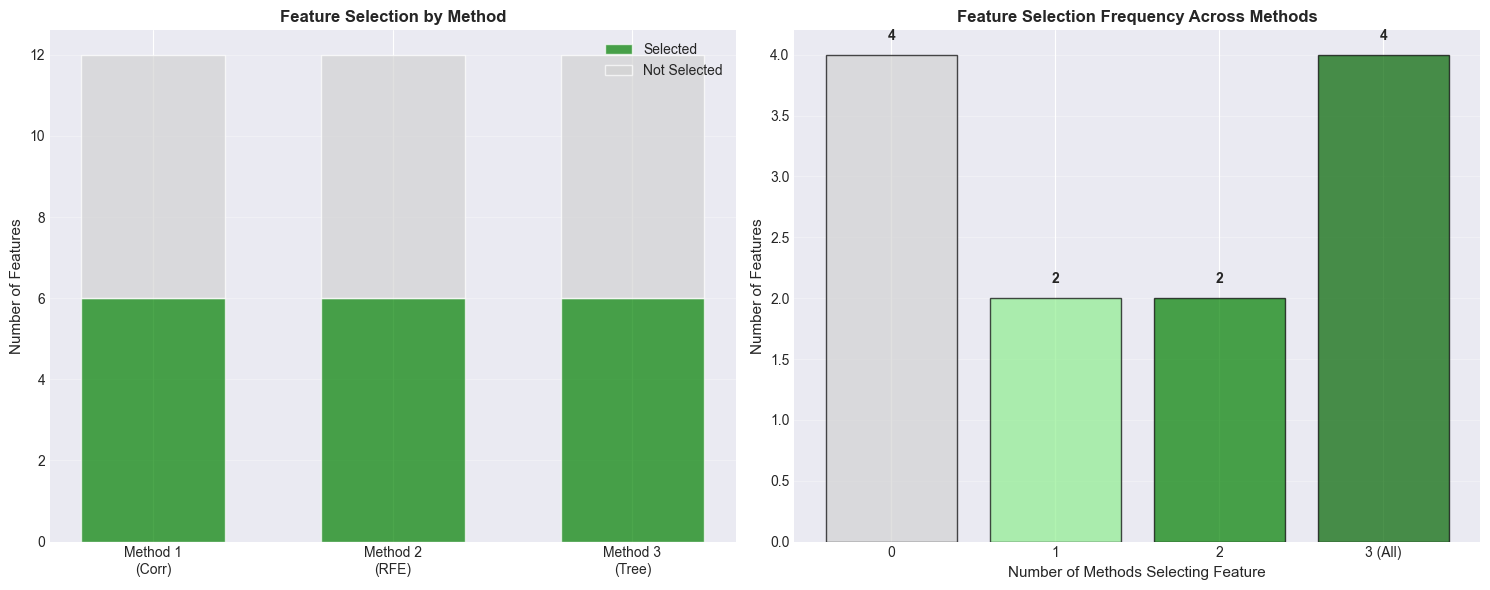